In [1]:
# imports

import numpy as np
from scipy.optimize import minimize
from scipy.signal import periodogram, find_peaks
from scipy.interpolate import interp1d
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
import copy

# global parameter definitions

f_sampling = 1000 # Hz
f_1 = f_sampling/60 # lowest possible frequency of a vibration mode
f_2 = f_sampling/3 # highest possible frequency of a vibration mode
f_w = f_sampling/3 # frequency above which measurement noise dominates
N_vib_app = 10 # number of vibration modes being applied
N_vib_max = 10 # number of vibration modes to be detected
energy_coeff = 1e-6 # proportion of total energy after which PSD curve fit ends
measurement_noise = 0.06 # milliarcseconds; pulled from previous notebook

Applied frequencies: [293.46047223  36.00129157 256.54668485 238.80730872 234.60992117
  57.80758373 317.3845448  230.37488068 302.77679355 121.27138462]


Text(0.5,1,'Vibrations without measurement noise')

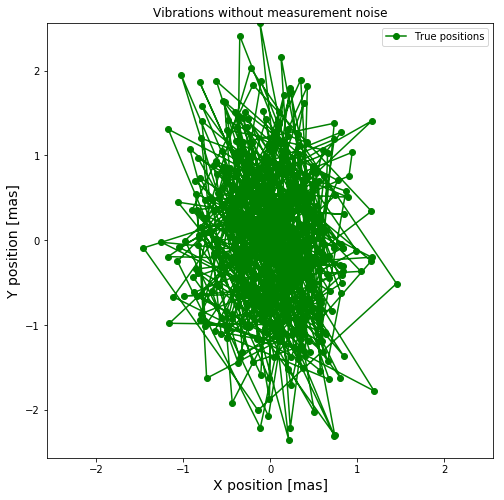

In [2]:
# step 1: making vibration data

times = np.arange(0, 0.5, 1/f_sampling)
vib_freqs    = np.random.uniform(low=f_1, high=f_2, size=N_vib_app)  # Hz
vib_amps     = np.random.uniform(low=0.1, high=1, size=N_vib_app) # milliarcseconds
vib_pa       = np.random.uniform(low=0.0, high=2*np.pi, size=N_vib_app)  # radians
vib_phase   = np.random.uniform(low=0.0, high=2*np.pi, size=N_vib_app)  # radians
vib_damping  = np.random.uniform(low=1e-4, high=1e-3, size=N_vib_app) # unitless

print("Applied frequencies: " + str(vib_freqs))
'''print("Applied amplitudes: " + str(vib_amps))
print("Applied amplitude polar angles: " + str(vib_pa))
print("Applied phase offsets: " + str(vib_phase))
print("Applied damping coefficients: " + str(vib_damping))'''

# vibrations are vib_amps[i] sin/cos(vib_pa[i]) exp(-vib_damping[i] vib_freqs[i] t) exp(i*(vib_freqs[i] t - vib_phase[i])).

def rotation_matrix(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array(((c,-s), (s, c)))

# to do: investigate why this is not equivalent to the summation formulas I had in here before.
true_positions = np.zeros((len(times),2))
    
for i in range(N_vib_app):
    y_init_of_t = vib_amps[i]*np.sin(2*np.pi*vib_freqs[i]*times-vib_phase[i])*np.exp(-vib_damping[i]*2*np.pi*vib_freqs[i]*times)
    x_init_of_t = np.zeros(len(times))
    positions_init = np.vstack((x_init_of_t, y_init_of_t))
    rotated_positions = np.dot(rotation_matrix(vib_pa[i]) , positions_init)
    true_positions = (true_positions + np.transpose(rotated_positions))
    
true_positions = true_positions.T
    
dx = true_positions[0]
dy = true_positions[1]

# measurement noise
dx_noisy = dx + np.random.normal(0, measurement_noise, np.size(times))
dy_noisy = dy + np.random.normal(0, measurement_noise, np.size(times))

plt.figure(figsize=(8, 8))
plt.plot(dx, dy, 'go-', label='True positions')
#plt.plot(dx_noisy, dy_noisy, 'ro-', label='Noisy positions')
plt.xlabel('X position [mas]',fontsize=14)
plt.ylabel('Y position [mas]',fontsize=14)
lim = max(np.max(np.abs(dx_noisy)), np.max(np.abs(dy_noisy)))
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

plt.legend()
#plt.title('Vibrations with and without measurement noise')
plt.title('Vibrations without measurement noise')


In [3]:
# step 2: find PSD
# TODO: refactor (probably in the class implementation) so that this only operates on one mode at a time.

_, psd_tip_true = periodogram(dx, f_sampling)
freqs_tip, psd_tip = periodogram(dx_noisy, f_sampling)
_, psd_tilt_true = periodogram(dy, f_sampling)
freqs_tilt, psd_tilt = periodogram(dy_noisy, f_sampling)

(1e-07, 1)

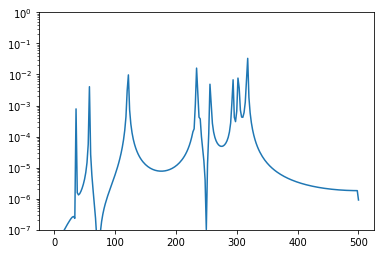

In [4]:
plt.semilogy(freqs_tip, psd_tip_true) # tilt is similar, but with slightly different peak amplitudes.
plt.ylim(1e-7,1)

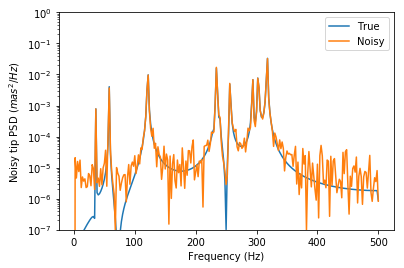

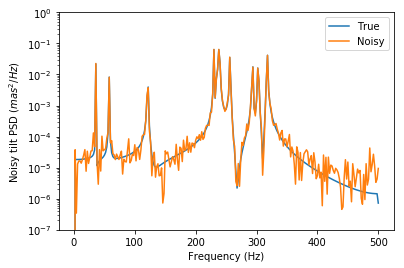

In [5]:
plt.semilogy(freqs_tip, psd_tip_true, label='True')
plt.semilogy(freqs_tip, psd_tip, label='Noisy')
plt.ylim(1e-7,1)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Noisy tip PSD $(mas^2/Hz)$")
plt.legend()
plt.show()

plt.semilogy(freqs_tilt, psd_tilt_true,   label='True')
plt.semilogy(freqs_tilt, psd_tilt, label='Noisy')
plt.ylim(1e-7,1)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Noisy tilt PSD $(mas^2/Hz)$")
plt.legend()
plt.show()

In [6]:
# step 3: filter out measurement noise

ind = max(np.argmax(freqs_tip > f_w), np.argmax(freqs_tilt > f_w))
assert ind != 0, "didn't find a high enough frequency"
noise_psd = (psd_tip[ind:] + psd_tilt[ind:])/2
avg_measurement_power = np.mean(noise_psd)

measurement_noise_recovered = np.sqrt(f_sampling * avg_measurement_power)
print("Recovered measurement noise: " + str(measurement_noise_recovered))
print("Percent error in measurement noise estimate: " + str(100 * np.abs(measurement_noise_recovered - measurement_noise)/measurement_noise))

psd_tip -= avg_measurement_power
psd_tilt -= avg_measurement_power

# this subtraction is problematic because it goes negative, so quick correction here. Want a better way of doing this.

for psd in [psd_tip, psd_tilt]:
    for i, p in enumerate(psd):
        if p < 0:
            psd[i] = min(psd[psd > 0])

# squelch: removing noise by applying a smoothing filter (convolution with [0.05, 0.1, 0.7, 0.1, 0.05])
conv_peak = 0.7
assert conv_peak < 1, "convolution must have unit gain"
side = 1 - conv_peak
kernel = np.array([side/6, side/3, conv_peak, side/3, side/6])
c = kernel.size//2
psd_tip_smooth = np.convolve(psd_tip, kernel)[c:-c]
psd_tilt_smooth = np.convolve(psd_tilt, kernel)[c:-c]

# ad hoc low-pass filter
ind_cutoff = max(np.argmax(freqs_tip > f_w), np.argmax(freqs_tilt > f_w))
psd_tip_smooth[ind_cutoff:] = np.zeros(len(psd_tip_smooth) - ind_cutoff)
psd_tilt_smooth[ind_cutoff:] = np.zeros(len(psd_tilt_smooth) - ind_cutoff)

# bring the peaks back to where they were
cutoff_amp = 1e-4 # arbitrary - should replace by some function of the measurement noise
peak_ind_tip = find_peaks(psd_tip_smooth, height=cutoff_amp)[0]
peak_ind_tilt = find_peaks(psd_tilt_smooth, height=cutoff_amp)[0]
for i in peak_ind_tip:
    psd_tip_smooth[i] = psd_tip_smooth[i]/conv_peak
for i in peak_ind_tilt:
    psd_tilt_smooth[i] = psd_tilt_smooth[i]/conv_peak
psd_tip = psd_tip_smooth
psd_tilt = psd_tilt_smooth


Recovered measurement noise: 0.14035819439851036
Percent error in measurement noise estimate: 133.93032399751726


Text(0.5,1,'Recovered+filtered and true PSDs')

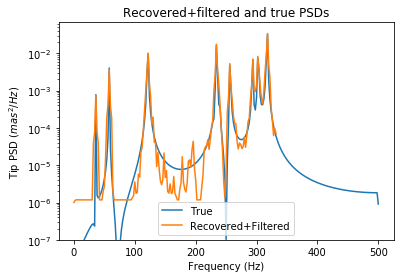

In [7]:
plt.semilogy(freqs_tilt, psd_tip_true, label='True')
plt.semilogy(freqs_tilt, psd_tip_smooth, label='Recovered+Filtered')
plt.ylim(1e-7, 2*max(psd_tip))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Tip PSD $(mas^2/Hz)$")
plt.legend()
plt.title("Recovered+filtered and true PSDs")
# filter isn't totally accurate, but it mostly picks out the peaks cleanly
# could try and LPF the noise (which I guess would be slicing in time because fft of fft) but could also just not

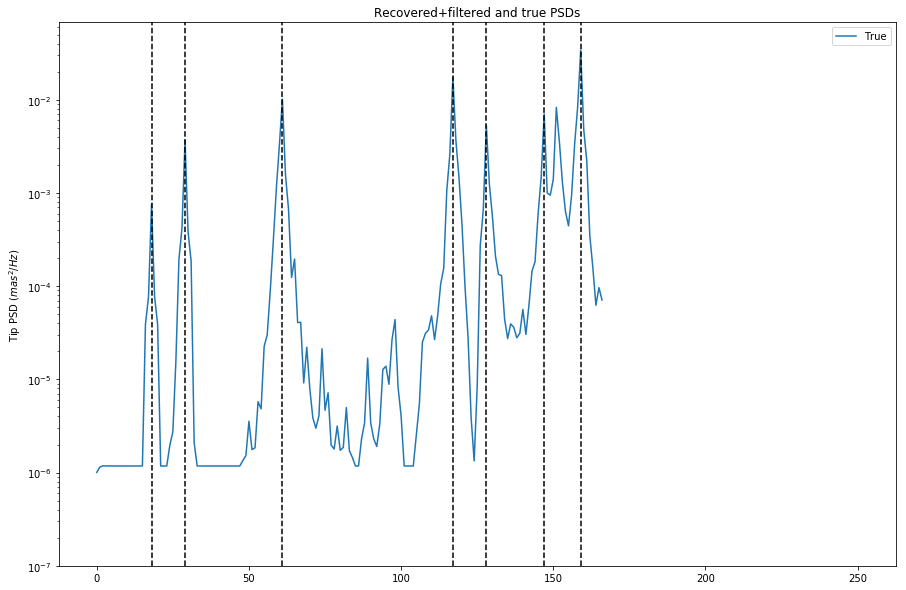

In [18]:
reference_shape = psd_tip_true[np.argmax(psd_tip_smooth)-10:np.argmax(psd_tip_smooth)+10]
N_peaks = 7

mycorr = []
psd_windowed = copy.deepcopy(psd_tip_smooth)

for i in range(N_peaks):
    mycorr_i = np.correlate(psd_windowed, reference_shape, 'same')
    mycorr.append(mycorr_i)
    psd_windowed[np.argmax(mycorr_i)-10:np.argmax(mycorr_i)+10] = 1e-6

plt.figure(figsize=(15,10))
plt.semilogy(psd_tip_smooth, label='True')
for i in range(N_peaks):
    plt.semilogy(np.ones(10)*np.argmax(mycorr[i]), np.linspace(1e-7, 2*max(psd_tip),10), 'k--')

plt.ylim(1e-7, 2*max(psd_tip))
plt.ylabel("Tip PSD $(mas^2/Hz)$")
plt.title("Recovered+filtered and true PSDs")
plt.legend()
plt.show()
